## Import libraries & download dependencies

In [88]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy import loadtxt
import tensorflow.keras
from PIL import Image, ImageOps
%matplotlib inline

### Path configuration

In [89]:
train_dir = '/opt/ml/x-ray project/X-ray-project/images/train'
test_dir = '/opt/ml/x-ray project/X-ray-project/images/test'

### Image size & batch size

In [90]:
img_width, img_height = 200, 160
batch_size = 32
steps_per_epoch = 32

### Create image generator

In [91]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                              height_shift_range= 0.02, 
                              width_shift_range=0.02, 
                              rotation_range=0.02, 
                              shear_range = 0.01,
                              fill_mode='nearest',
                              zoom_range=0.01)

### Train generator & Test generator

In [92]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 9237 images belonging to 3 classes.


In [93]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 1596 images belonging to 3 classes.


In [94]:
train_generator.class_indices

{'normal': 0, 'pneumonia': 1, 'tuberculosis': 2}

### Download pretrained model (Xception)

In [95]:
pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False)
pretrained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [96]:
## Freeze all weights of the pretrained models
pretrained_model.trainable = False
pretrained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Create output layer of Xception model

In [97]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

In [98]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

### Train the model

In [99]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam', 
    metrics=["accuracy"]
)

filepath="xceptionv3_best_avg_imgSize.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001
)

callbacks_list = [checkpoint, learning_rate_reduction]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=20,
    verbose=1)

Epoch 1/20
32/32 [==============================] - 29s 825ms/step - loss: 0.5588 - accuracy: 0.8125 - val_loss: 0.3972 - val_accuracy: 0.8687

Epoch 00001: val_loss improved from inf to 0.39715, saving model to xceptionv3_best_avg_imgSize.h5
Epoch 2/20
32/32 [==============================] - 26s 796ms/step - loss: 0.2788 - accuracy: 0.8926 - val_loss: 0.6527 - val_accuracy: 0.8375

Epoch 00002: val_loss did not improve from 0.39715
Epoch 3/20
32/32 [==============================] - 26s 793ms/step - loss: 0.3166 - accuracy: 0.8857 - val_loss: 0.3546 - val_accuracy: 0.8750

Epoch 00003: val_loss improved from 0.39715 to 0.35458, saving model to xceptionv3_best_avg_imgSize.h5
Epoch 4/20
32/32 [==============================] - 26s 788ms/step - loss: 0.3241 - accuracy: 0.8740 - val_loss: 0.2212 - val_accuracy: 0.9125

Epoch 00004: val_loss improved from 0.35458 to 0.22117, saving model to xceptionv3_best_avg_imgSize.h5
Epoch 5/20
32/32 [==============================] - 26s 787ms/step -

### Validation

**Accuracy**

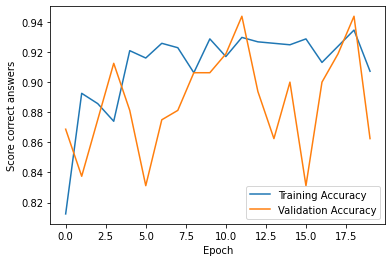

In [100]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score correct answers')
plt.legend()
plt.show()

**loss**

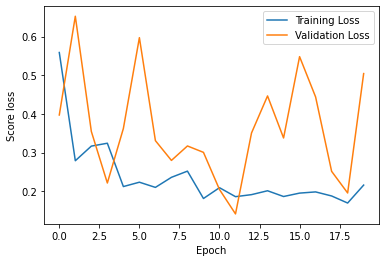

In [101]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Score loss')
plt.legend()
plt.show()

### Fine tuning the convolutional layers of Xception

**Download the best weights**

In [102]:
model.load_weights("xceptionv3_best_avg_imgSize.h5")

OSError: Unable to open file (unable to open file: name = 'xceptionv3_best_avg_imgSize.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

**Unfreeze the last 2 blocks of Xception**

In [103]:
pretrained_model.trainable = False
for layer in model.layers[:290]:
    layer.trainable = False
for layer in model.layers[290:]:
    layer.trainable = True

**Retrain the model**

In [104]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=["accuracy"])

filepath="xceptionv3_fine_tuned_avg_imgSize.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, learning_rate_reduction]

history = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=40,
    verbose=2)

Epoch 1/40
32/32 - 29s - loss: 0.1562 - accuracy: 0.9443 - val_loss: 0.1805 - val_accuracy: 0.9438

Epoch 00001: val_accuracy improved from -inf to 0.94375, saving model to xceptionv3_fine_tuned_avg_imgSize.h5
Epoch 2/40
32/32 - 26s - loss: 0.1462 - accuracy: 0.9502 - val_loss: 0.1955 - val_accuracy: 0.9375

Epoch 00002: val_accuracy did not improve from 0.94375
Epoch 3/40
32/32 - 26s - loss: 0.1962 - accuracy: 0.9258 - val_loss: 0.1992 - val_accuracy: 0.9250

Epoch 00003: val_accuracy did not improve from 0.94375
Epoch 4/40
32/32 - 26s - loss: 0.1816 - accuracy: 0.9385 - val_loss: 0.2199 - val_accuracy: 0.9250

Epoch 00004: val_accuracy did not improve from 0.94375
Epoch 5/40
32/32 - 26s - loss: 0.1940 - accuracy: 0.9258 - val_loss: 0.2256 - val_accuracy: 0.9438

Epoch 00005: val_accuracy did not improve from 0.94375
Epoch 6/40
32/32 - 26s - loss: 0.2006 - accuracy: 0.9277 - val_loss: 0.2800 - val_accuracy: 0.8813

Epoch 00006: val_accuracy did not improve from 0.94375
Epoch 7/40
32/3

### Validation

**accuracy**

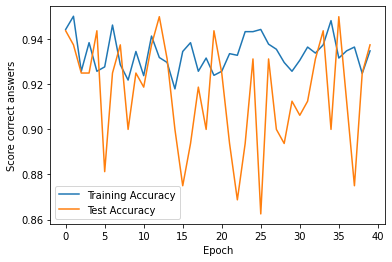

In [105]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Score correct answers')
plt.legend()
plt.show()

**loss**

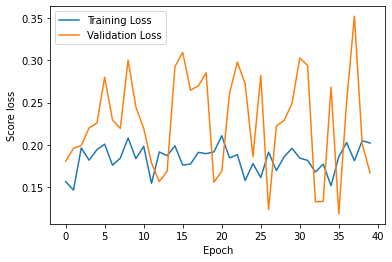

In [106]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Score loss')
plt.legend()
plt.show()

## Confusion matrix

In [120]:
from tensorflow import keras
saved_model = keras.models.load_model('/opt/ml/x-ray project/models/inceptionv3_imgSize_299.h5')

In [121]:
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

def cm_plot_1(model):
    y_true = test_generator.classes
    Y_pred = model.predict(test_generator, steps = len(test_generator))
    cf_matrix = confusion_matrix(y_true, [Y_pred[i].argmax() for i in range(len(Y_pred))])
    plot_confusion_matrix(cf_matrix, hide_ticks = True, cmap = plt.cm.Blues)
    plt.title("Confusion Matrix", fontsize = 22) 
    plt.xticks(range(3), ['Normal','Pneumonia','Tuberculosis'], fontsize = 10)
    plt.yticks(range(3), ['Normal','Pneumonia','Tuberculosis'], fontsize = 10)

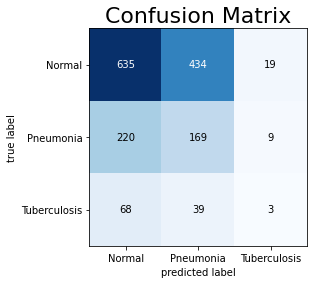

In [124]:
cm_plot_1(saved_model)

## Summary

In [125]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

y_true = test_generator.classes
Y_pred = avg_imgSize_model.predict(test_generator, steps = len(test_generator))
y_pred = [Y_pred[i].argmax() for i in range(len(Y_pred))]
print("Accuracy: ", accuracy_score(y_true, y_pred))
print("F1 Score: ", f1_score(y_true, y_pred, average="macro"))
print("Precision: ", precision_score(y_true, y_pred, average="macro"))
print("Recall: ", recall_score(y_true, y_pred, average="macro"))

Average:  0.5219298245614035
F1 Score:  0.32380689397647605
Precision:  0.3298273049824278
Recall:  0.3230733099544066
